In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import fsolve

In [2]:
class Bidder:
    
    def __init__(self, budget, level=0):
        self.budget = budget
        self.level = level
        self.profit = 0
        
    def gen_preferences(self, dist, N_objects):
        self.preferences = dist.rvs(N_objects).round(2) + self.level
        
    def update_preferences(self):
        """
        secures that the bidder does not exceed his budget
        """
        self.preferences = np.where(self.preferences>self.budget, self.budget, self.preferences)
        
class Auction:
    
    def __init__(self, N_objects, N_bidders, dist, auction_log=None, bidders_log=None, x0=0, replace=True):
        self.N_objects = N_objects
        self.N_bidders = N_bidders
        self.dist = dist
        self.replace = replace
        self.objects = np.arange(N_objects)
        self.rounds = 0
        
        if auction_log:
            self.auctionTracker = pd.DataFrame(columns=auction_log)
        if bidders_log:
            self.biddersTracker = pd.DataFrame(columns=['round', 'bidder'] + bidders_log)
        
        # call bidders
        self.bidders = []
        self.pref_matrix = np.empty((self.N_bidders, self.N_objects))
        for i in range(self.N_bidders):
            budget = np.random.randint(8, 11)
#             budget = 10
            b = Bidder(budget)
            b.gen_preferences(self.dist, self.N_objects)
            self.pref_matrix[i, :] = b.preferences
            b.objects_won = np.zeros(self.N_objects)
            self.bidders.append(b) 
    
    def one_round(self):
        obj = np.random.choice(self.objects)
        bids = self.pref_matrix[:, obj]
        winner = bids.argmax()
        payment = np.where(bids == np.max(bids), 0, bids).max()
        self.highest_bid = np.max(bids)
        self.bidders[winner].budget -= payment
        self.bidders[winner].objects_won[obj] += 1
        self.bidders[winner].profit += self.highest_bid - payment
        [auc.bidders[i].update_preferences() for i in range(auc.N_bidders)]
        self.pref_matrix = np.array([auc.bidders[i].preferences for i in range(auc.N_bidders)])
        self.budgets = np.array([auc.bidders[i].budget for i in range(auc.N_bidders)])
#         print(bids)
#         print(self.highest_bid)
#         print(payment)
        
        # auction log
        self.auctionTracker = self.auctionTracker.append(pd.DataFrame([self.__dict__[var] for var in self.auctionTracker.columns], columns = self.auctionTracker.columns))
        self.auctionTracker.index = np.arange(0, self.auctionTracker.shape[0])
        
        # bidder log
        
        self.biddersTracker = self.biddersTracker.append(pd.DataFrame(np.concatenate([np.ones((self.N_bidders, 1))*self.rounds, 
                                                               np.arange(self.N_bidders).reshape(-1,1), 
                                                               self.budgets.reshape(-1,1)], axis=1), columns=['round', 'bidder', 'budgets']))
        
        
        self.rounds += 1
        
dist = stats.lognorm(0.5, scale=np.exp(0.5))
b1 = Bidder(20)

auc = Auction(N_objects=10, N_bidders=5, dist=dist, auction_log=['highest_bid'], bidders_log=['budgets'])
# auc.call_bidders(dist)
[auc.bidders[i].budget for i in range(auc.N_bidders)]

[8, 9, 10, 8, 8]

In [3]:
for _ in range(30):
    auc.one_round()
# print([round(auc.bidders[i].budget, 2) for i in range(auc.N_bidders)])
# print([round(auc.bidders[i].profit, 2) for i in range(auc.N_bidders)])

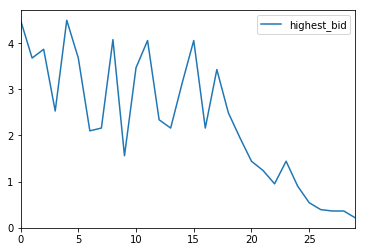

In [4]:
auc.auctionTracker.plot()

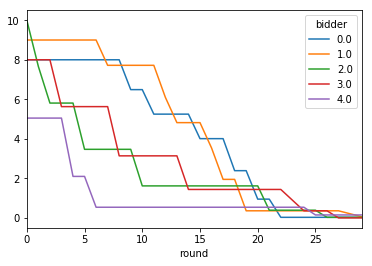

In [5]:
df = auc.biddersTracker.copy()
df.pivot(index='round', columns='bidder', values='budgets').plot()